In [32]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Rescaling
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomFlip, RandomRotation, RandomTranslation, RandomCrop, RandomBrightness, GaussianNoise
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from absl import logging

logging.set_verbosity(logging.ERROR)
np.set_printoptions(suppress=True)
AUTOTUNE = tf.data.AUTOTUNE

#### Loading Dataset


In [3]:
classes_name = os.listdir("./dataset/train/")
dict_disease = {}

for number, name in enumerate(classes_name):
    if name == 'filename':continue              # skip 1st column
    dict_disease[number] = name.strip()
dict_disease = {key: dict_disease[key] for key in dict_disease if key != 'Unlabeled'}
img_size = 224

In [ ]:
with tf.device('/cpu:0'):
    path_train = "./dataset/train/"
    path_valid = "./dataset/valid/"
    path_test = "./dataset/test/"
    train_dataset = tf.keras.utils.image_dataset_from_directory(path_train, shuffle=False, batch_size=None, image_size=(img_size,img_size))
    valid_dataset = tf.keras.utils.image_dataset_from_directory(path_valid, shuffle=False, batch_size=None, image_size=(img_size,img_size))
    test_dataset = tf.keras.utils.image_dataset_from_directory(path_test, shuffle=False, batch_size=None, image_size=(img_size,img_size))

    test_labels = []
    for _, label in test_dataset:
        test_labels.append(label.numpy())
    test_labels = np.array(test_labels).reshape(-1,1)

In [5]:
with tf.device('/cpu:0'):
    train = train_dataset.cache('train_dataset').repeat(1).shuffle(256, reshuffle_each_iteration=True).batch(32).prefetch(AUTOTUNE)
    valid = valid_dataset.cache('valid-dataset').batch(32).prefetch(AUTOTUNE)
    test = test_dataset.cache('test-dataset').batch(32).prefetch(AUTOTUNE)

In [6]:
def confusionMatrix(epoch, logs):
    test_loss, test_acc, topK_acc = model.evaluate(test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}\nTest Accuracy: {test_acc*100:.2f}%\nTopK Accuracy: {topK_acc*100:.2f}%")
    
    yhat = model.predict(test, verbose=0)
    yhat = np.argmax(yhat, axis=1)
    ConfusionMatrixDisplay.from_predictions(
        test_labels, 
        yhat, 
        display_labels=dict_disease.values(),
        xticks_rotation=45
    )
    plt.title(f"Confusion Matrix on epoch {epoch+1}\nVal accuracy: {logs.get('val_accuracy'):.3f}\nTest accuracy: {model.evaluate(test)[1]:.3f}")

    try:
        os.makedirs("./CM/")
    except FileExistsError:
        pass

    plt.savefig(f"./CM/Epoch {epoch+1}.png", dpi=300, bbox_inches='tight')
    plt.close('all')

### Buat Model


In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_size,img_size,3), include_top=False, include_preprocessing=False, pooling='max')
base_model.trainable=False

# for layer in base_model.layers[:100]:
#     layer.trainable=False

model = Sequential([
    Input((img_size, img_size, 3), dtype=tf.float32),
    GaussianNoise(stddev=0.5),
    Rescaling(1/255),
    RandomFlip(),
    RandomRotation(factor=0.3),
    RandomZoom(height_factor=(-0.2, 0.2)),
    RandomBrightness(factor=(-0.2,0.2), value_range=[0,1]),
    base_model,
    Dense(128, activation='selu'),
    Dense(len(dict_disease))
])

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

bestCB = ModelCheckpoint(filepath='./checkpoint/best/', monitor='val_accuracy',
                         mode='max', verbose=1, save_best_only=True)

cmCB = LambdaCallback(on_epoch_end=confusionMatrix)

esCB = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

model.summary()

### Training Model


In [ ]:
# with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(
        train,
        validation_data=valid,
        epochs=1000,
        callbacks=[bestCB, cmCB, esCB]
    )

In [ ]:
model.save("./checkpoint/latest/")

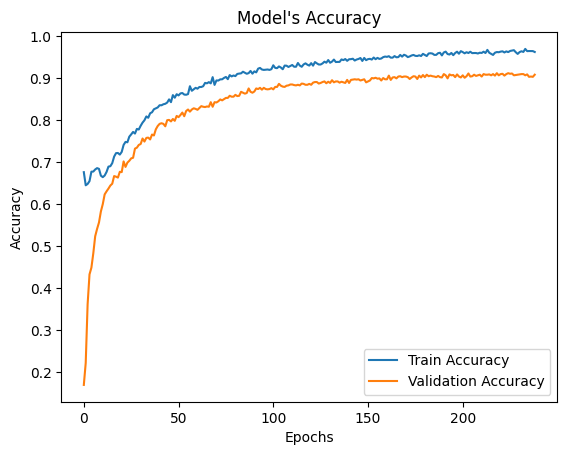

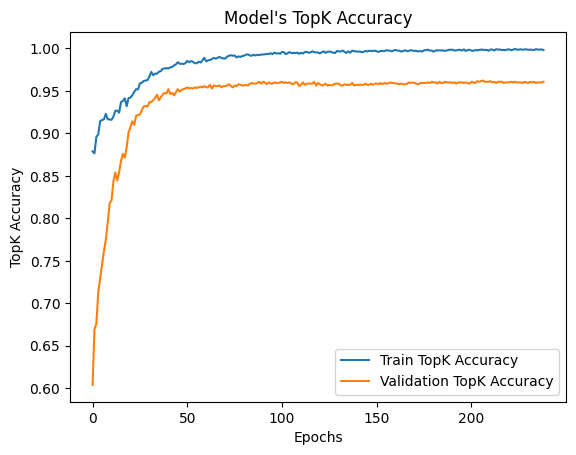

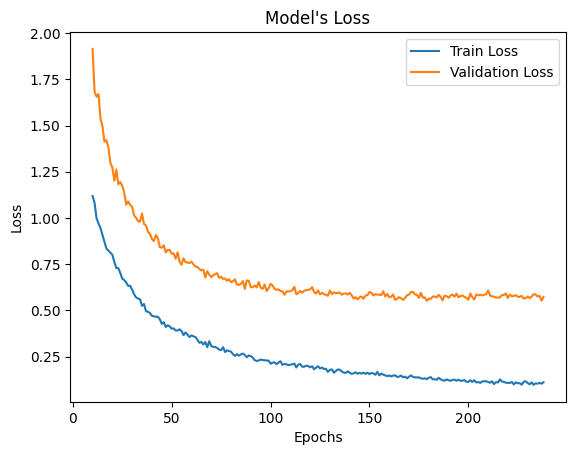

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
topK_acc = history.history['sparse_top_k_categorical_accuracy']
val_topK_acc = history.history['val_sparse_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model's Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, topK_acc, label='Train TopK Accuracy')
plt.plot(epochs, val_topK_acc, label='Validation TopK Accuracy')
plt.xlabel("Epochs")
plt.ylabel("TopK Accuracy")
plt.title("Model's TopK Accuracy")
plt.legend()
plt.show()

plt.plot(epochs[10:], loss[10:], label='Train Loss')
plt.plot(epochs[10:], val_loss[10:], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model's Loss")
plt.legend()
plt.show()

#### Evaluasi Model


In [7]:
# Load iterasi terakhir
# model = tf.keras.models.load_model("./checkpoint/latest/")

# Load terbaik
model = tf.keras.models.load_model("./checkpoint/best/")

In [8]:
test_loss, test_acc, topK_acc = model.evaluate(test, verbose=0)
print(f"Test Loss: {test_loss:.4f}\nTest Accuracy: {test_acc*100:.2f}%\nTopK Accuracy: {topK_acc*100:.2f}%")

Test Loss: 0.9939
Test Accuracy: 81.12%
TopK Accuracy: 92.07%


In [ ]:
topK = 3 # Ambil 3 kategori tertinggi untuk display ke user

for number, (image, label) in enumerate(test_dataset.shuffle(512).take(10)):
    image = tf.cast(image, tf.uint8)

    plt.imshow(image, interpolation='nearest')
    plt.title(dict_disease[label.numpy()])
    plt.axis('off')

    pred_image      = tf.cast(image, tf.float32)
    pred_image      = tf.expand_dims(image, axis=0)
    yhat            = tf.nn.softmax(model.predict(pred_image, verbose=0))
    yhat_topk       = np.argpartition(-yhat, topK-1)[0][:3]
    true_label      = dict_disease[label.numpy()]
    prob_res        = []
    disease_types   = []
    text_result     = []

    for disease in yhat_topk:
        disease_types.append(dict_disease[disease])
        prob_res.append(yhat[0][disease])

    for index_disease, disease in enumerate(disease_types):
        res = "benar" if true_label == disease else "salah"
        res = f"{index_disease+1}: {disease} ({res}), {prob_res[index_disease] * 100:.2f}%."
        text_result.append(res)
        
    plt.figtext(0.5, 0.01, "\n".join(text_result), ha='center', wrap=True)
    plt.show()

### Konversi ke TFLite

#### https://www.tensorflow.org/lite/performance/model_optimization

#### https://www.tensorflow.org/model_optimization/guide/quantization/training_example


In [37]:
# Optimize size
converter = tf.lite.TFLiteConverter.from_saved_model("./checkpoint/best/")
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

tflite_file = pathlib.Path('model size.tflite')
tflite_file.write_bytes(tflite_model)

3420432

In [38]:
# Optimize latency
converter = tf.lite.TFLiteConverter.from_saved_model("./checkpoint/best/")
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()

tflite_file = pathlib.Path('model latency.tflite')
tflite_file.write_bytes(tflite_model)

3420432